# Imports

In [97]:
import numpy as np
import scipy.fftpack as fp
import matplotlib.pylab as plt

from skimage import color
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.util import random_noise
from pyunlocbox import functions, solvers
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from skimage.metrics import peak_signal_noise_ratio as compare_psnr

# Utils

In [92]:
def convolve2d(im, psf, k):
    M, N = im.shape
    freq = fp.fft2(im)
    psf = np.pad(psf, (((M - k) // 2, (M - k) // 2 + 1), ((N - k) // 2, (N - k) // 2 + 1)), mode='constant')
    freq_kernel = fp.fft2(fp.ifftshift(psf))
    return np.abs(fp.ifft2(freq * freq_kernel))

In [93]:
def plot_image(im, title, cmap='gray'):
    plt.imshow(im, cmap=cmap)
    plt.axis('off')
    plt.title(title, size=20)


def plot_images(orig_image, noisy_image, denoised_image, titles):
    plt.figure(figsize=(15, 5))
    plt.subplot(131), plot_image(orig_image, titles[0])
    plt.subplot(132), plot_image(noisy_image, titles[1])
    plt.subplot(133), plot_image(denoised_image, titles[2])
    plt.tight_layout()
    plt.show()


def plot_freq(orig_image, noisy_image, denoised_image):
    fig = plt.figure(figsize=(15, 5))

    ax1 = fig.add_subplot(131, projection='3d')
    plot_freq_spec_3d(ax1, np.fft.fft2(orig_image))

    ax2 = fig.add_subplot(132, projection='3d')
    plot_freq_spec_3d(ax2, np.fft.fft2(noisy_image))

    ax3 = fig.add_subplot(133, projection='3d')
    plot_freq_spec_3d(ax3, np.fft.fft2(denoised_image))

    plt.show()

In [94]:
def plot_freq_spec_3d(ax, freq):
    Y = np.arange(-freq.shape[0] // 2, freq.shape[0] - freq.shape[0] // 2)
    X = np.arange(-freq.shape[1] // 2, freq.shape[1] - freq.shape[1] // 2)
    X, Y = np.meshgrid(X, Y)
    Z = (20 * np.log10(0.01 + np.fft.fftshift(freq))).real
    ax.plot_surface(X, Y, Z, cmap=plt.cm.coolwarm, linewidth=0, antialiased=True)

    ax.zaxis.set_major_locator(LinearLocator(10))
    ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Wiener Filter

In [63]:
def wiener(image, psf, balance=0.1):
    image_freq = fp.fft2(image)

    M, N = image.shape
    psf = np.pad(psf, (((M - psf.shape[0]) // 2, (M - psf.shape[0]) // 2 + 1),
                       ((N - psf.shape[1]) // 2, (N - psf.shape[1]) // 2 + 1)), mode='constant')

    psf_freq = fp.fft2(fp.ifftshift(psf))
    wiener_filter = np.conj(psf_freq) / (np.abs(psf_freq) ** 2 + balance)
    restored_freq = image_freq * wiener_filter
    restored_image = np.abs(fp.ifft2(restored_freq))

    return restored_image

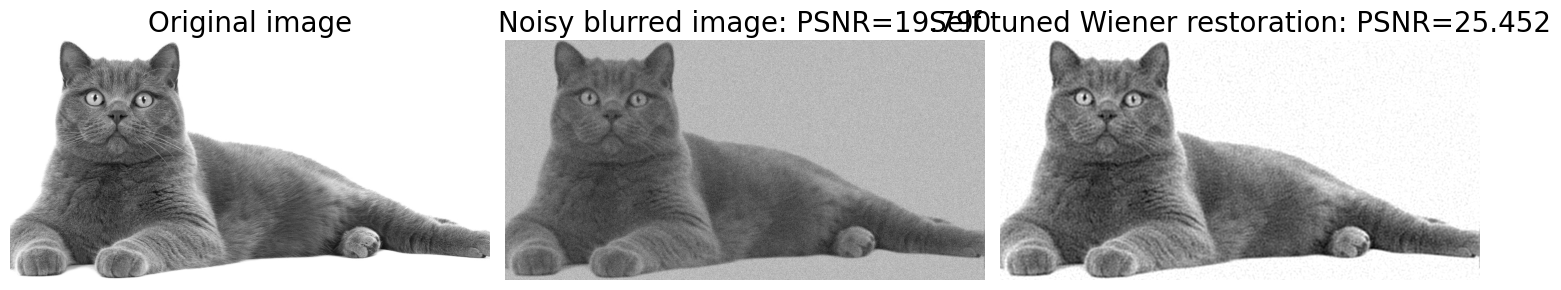

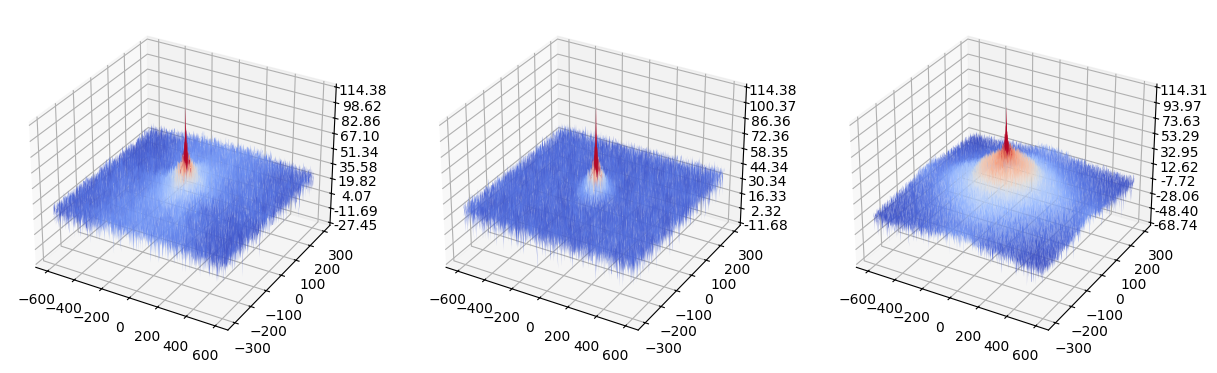

In [83]:
k = 5
psf = np.ones((k, k)) / k ** 2

im = color.rgb2gray(imread('images/cat.jpeg'))
im1 = convolve2d(im, psf, k)
im1 += 0.3 * im.std() * np.random.standard_normal(im.shape)
im2 = wiener(im1, psf, balance=0.5)

titles = [
    'Original image',
    'Noisy blurred image: PSNR={:.3f}'.format(compare_psnr(im, im1)),
    'Self tuned Wiener restoration: PSNR={:.3f}'.format(compare_psnr(im, im2))
]
plot_images(im, im1, im2, titles)
plot_freq(im, im1, im2)

# Constrained Least Squares (CLS) Filter

In [65]:
def cls_filter(y, h, c, lambd):
    Hf = fp.fft2(fp.ifftshift(h))
    Cf = fp.fft2(fp.ifftshift(c))
    Hf = np.conj(Hf) / (Hf * np.conj(Hf) + lambd * Cf * np.conj(Cf))
    Yf = fp.fft2(y)
    I = Yf * Hf
    im = np.abs(fp.ifft2(I))
    return (im, Hf)

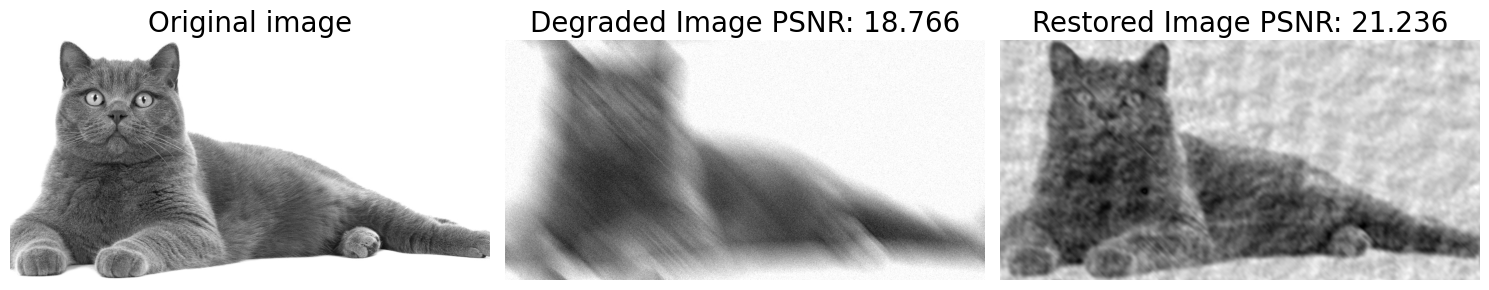

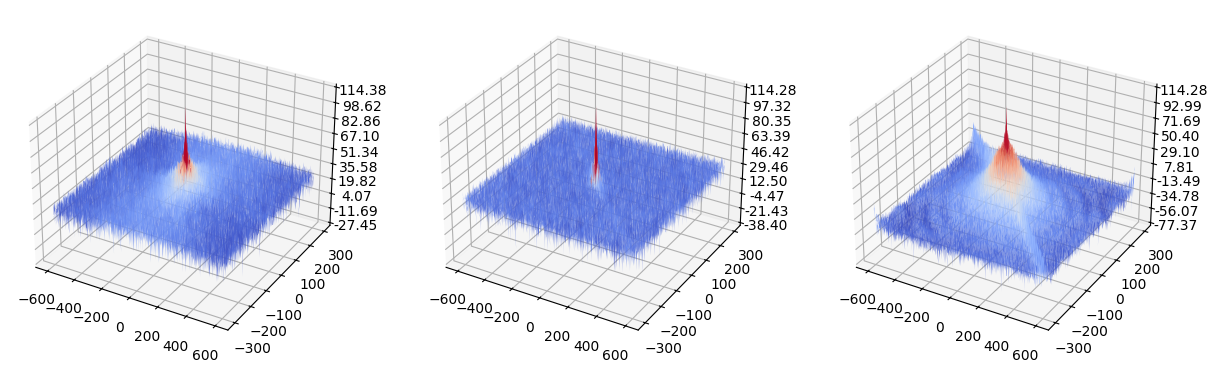

In [88]:
im = rgb2gray(imread('images/cat.jpeg'))

(M, N), k = im.shape, 81
kernel = np.zeros((k, k))
for i in range(k):
    kernel[i, i] = 1

kernel = kernel / k
im_blur = convolve2d(im, kernel, k)
im_blur = random_noise(im_blur, var=0.0025)

x = im
y = im_blur
h = kernel

h = np.pad(h, [(M // 2 - k // 2, M // 2 - k // 2 - 1), (N // 2 - k // 2, N // 2 - k // 2 - 1)], mode='constant')

c = np.array([[0, 1 / 4, 0], [1 / 4, -1, 1 / 4], [0, 1 / 4, 0]])
c = np.pad(c, [(M // 2 - 1, M // 2 - 2), (N // 2 - 2, N // 2 - 1)], mode='constant')
Cf = fp.fft2(fp.ifftshift(c))

_lambda = 7.5
clx, F_restored = cls_filter(y, h, c, _lambda)

titles = [
    'Original image',
    'Degraded Image PSNR: {}'.format(np.round(compare_psnr(x, y), 3)),
    r'Restored Image PSNR: {}'.format(np.round(compare_psnr(x, clx), 3))
]
plot_images(im, im_blur, clx, titles)
plot_freq(im, im_blur, clx)

# Markov Random Field

In [95]:
def read_image_and_binarize(image_file, threshold=128):
    im = (255 * rgb2gray(plt.imread(image_file))).astype(int)
    im[im < threshold] = -1
    im[im >= threshold] = 1
    return im


def add_noise(im):
    im_noisy = im.copy()
    for i in range(im_noisy.shape[0]):
        for j in range(im_noisy.shape[1]):
            r = np.random.rand()
            if r < 0.1:
                im_noisy[i][j] = -im_noisy[i][j]
    return im_noisy


def compute_energy_helper(Y, i, j):
    try:
        return Y[i][j]
    except IndexError:
        return 0


def compute_energy(X, Y, i, j, zeta, eta, Y_i_j):
    energy = -eta * X[i][j] * Y_i_j
    for (k, l) in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
        energy -= zeta * Y_i_j * compute_energy_helper(Y, i + k, j + l)
    return energy


def denoise_image(O, X, zeta, eta):
    m, n = np.shape(X)
    Y = np.copy(X)
    max_iter = 10 * m * n

    for iter in range(max_iter):
        i = np.random.randint(m)
        j = np.random.randint(n)

        energy_neg = compute_energy(X, Y, i, j, zeta, eta, -1)
        energy_pos = compute_energy(X, Y, i, j, zeta, eta, 1)

        if energy_neg < energy_pos:
            Y[i][j] = -1
        else:
            Y[i][j] = 1

    return Y

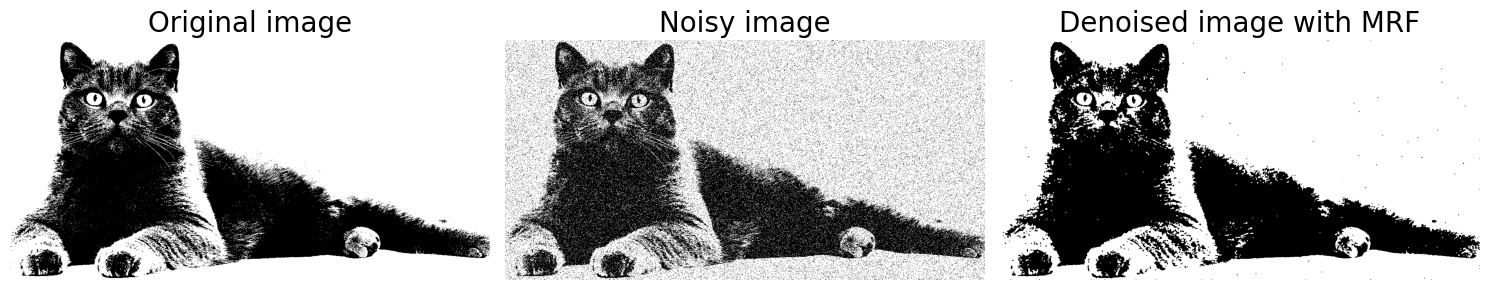

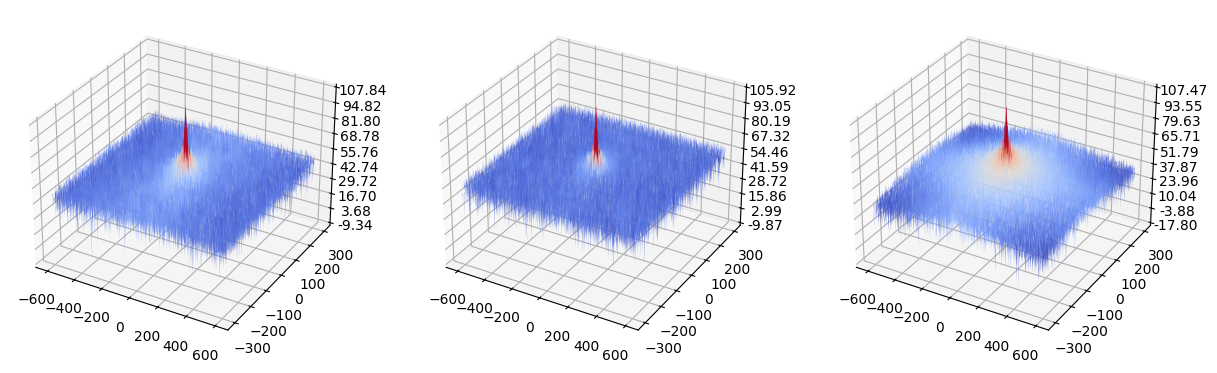

In [96]:
orig_image = read_image_and_binarize('images/cat.jpeg')
zeta = 1.5
eta = 2

noisy_image = add_noise(orig_image)
denoised_image = denoise_image(orig_image, noisy_image, zeta, eta)

titles = [
    'Original image',
    'Noisy image',
    'Denoised image with MRF'
]
plot_images(orig_image, noisy_image, denoised_image, titles)
plot_freq(orig_image, noisy_image, denoised_image)

# Convex Optimization

Solution found after 100 iterations:
    objective function f(sol) = 1.141569e+04
    stopping criterion: MAXIT


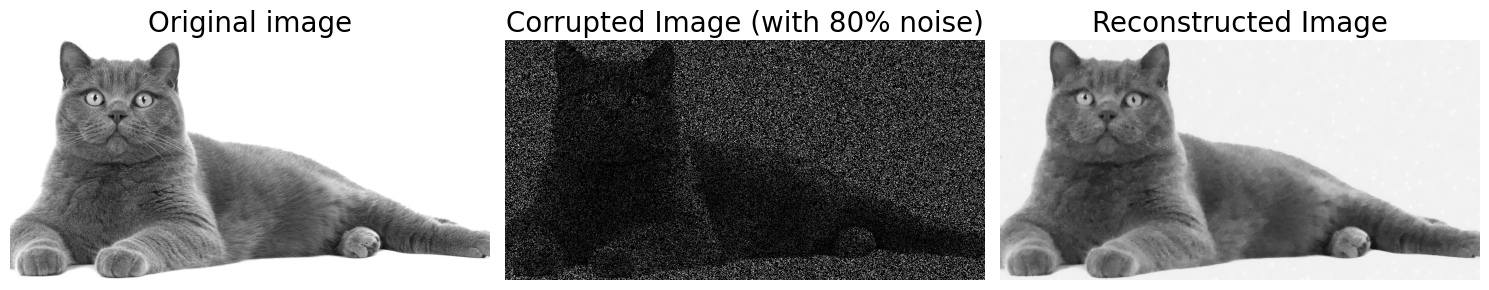

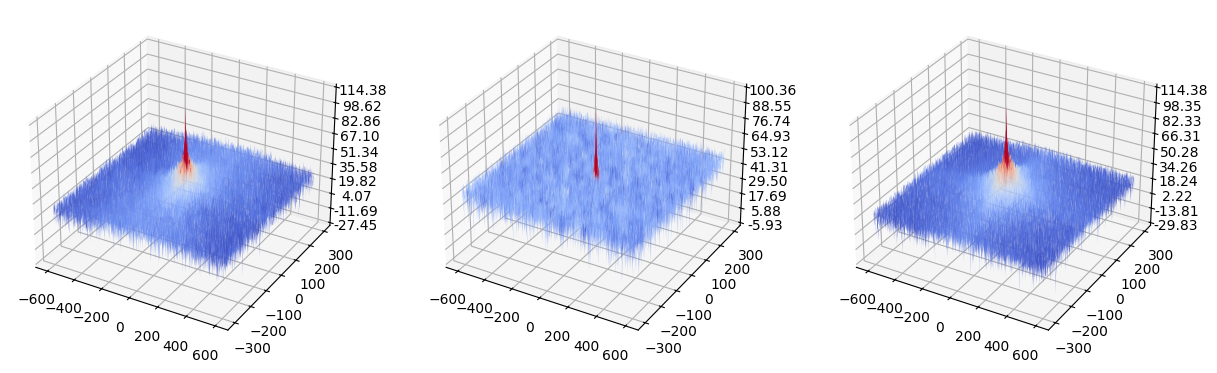

In [122]:
im_original = rgb2gray(imread('images/cat.jpeg'))
np.random.seed(1)

mask = np.random.uniform(size=im_original.shape)
mask = mask > 0.8

g = lambda x: mask * x
im_corrupted = g(im_original)

f1 = functions.norm_tv(maxit=50, dim=2)
tau = 100
f2 = functions.norm_l2(y=im_corrupted, A=g, lambda_=tau)
solver = solvers.forward_backward(step=0.5/tau)
x0 = np.array(im_corrupted)
ret = solvers.solve([f1, f2], x0, solver, maxit=100)

titles = [
    'Original image',
    'Corrupted Image (with 80% noise)',
    'Reconstructed Image'
]
plot_images(im_original, im_corrupted, ret['sol'], titles)
plot_freq(im_original, im_corrupted, ret['sol'])